#### ИНИЦИАЛИЗАЦИЯ

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

font_path = "/home/nekkon/my_fonts/tilda-sans_medium.ttf"

fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()

sns.set_theme(style="whitegrid", context="talk")

plt.rcParams.update({
    "font.family": font_name,
    "font.weight": "medium",
    "axes.labelweight": "medium",
    "axes.titleweight": "medium",
    "axes.labelsize": 24,
    "axes.titlesize": 28,
    "figure.facecolor": "#F6F6F6",
    "axes.facecolor": "#F6F6F6",
    "savefig.format": "png",
})

font_prop = fm.FontProperties(fname=font_path)

# (стандартный шрифт)
try:
    font_prop
    print('tilda-sans')
except NameError:
    font_prop = fm.FontProperties(family='DejaVu Sans') 
    print('Щрифт не найден, используется DejaVu Sans')

tilda-sans


In [2]:
flats = pd.read_csv('Final_Flats.csv')
deals = pd.read_csv('Final_Deals.csv')

In [3]:
def merge_flats_to_deals(flats_df, deals_df):
    """
    Объединяет данные из flats в deals по ID корпуса
    """
    print("Начало объединения flats в deals...")

    cols = flats_df.columns
    new_cols = []
    for col in cols:
        if col == 'Этожей до':
            new_cols.append('Этажей до')
        else:
            new_cols.append(col)
    flats_df.columns = new_cols

    flats_agg = flats_df.groupby('ID корпуса')[['Этажей от', 'Этажей до']].min().reset_index()
    deals_df = deals_df.merge(flats_agg, on='ID корпуса', how='left')

    flats_agg = flats_df.groupby('ID корпуса')['Плановая дата РВЭ'].min().reset_index()
    deals_df = deals_df.merge(flats_agg, on='ID корпуса', how='left')

    flats_agg = flats_df.groupby('ID корпуса')['Стадия строительства'].min().reset_index()
    deals_df = deals_df.merge(flats_agg, on='ID корпуса', how='left')

    flats_df['Общая проектная площадь'] = pd.to_numeric(
        flats_df['Общая проектная площадь'], errors='coerce'
    )

    flats_agg = flats_df.groupby('ID корпуса')['Общая проектная площадь'].sum().reset_index()
    deals_df = deals_df.merge(flats_agg, on='ID корпуса', how='left')
    deals_df['Общая проектная площадь'] = pd.to_numeric(
        deals_df['Общая проектная площадь'], errors='coerce'
    ).fillna(0)

    deals_df['Ипотека'] = deals_df['Ипотека'].apply(
        lambda x: 1 if str(x).strip().lower() == 'ипотека' else 0
    )

    deals_df['Суммарная площадь сделок'] = pd.to_numeric(
        deals_df['Суммарная площадь сделок'], errors='coerce'
    ).fillna(0)

    deals_df['Сумма бюджета'] = pd.to_numeric(
        deals_df['Сумма бюджета'], errors='coerce'
    ).fillna(0)

    deals_df['Количество комнат'] = deals_df['Количество комнат'].astype(str).apply(
        lambda x: x if x.isdigit() else 0
    )

    deals_df['Суммарное количество сделок'] = pd.to_numeric(
        deals_df['Суммарное количество сделок'], errors='coerce'
    ).fillna(0)

    deals_df['Цена квадратного метра'] = (
            deals_df['Сумма бюджета'] / deals_df['Суммарная площадь сделок']
    )

    print("Объединение flats в deals завершено")
    return deals_df


df = merge_flats_to_deals(flats, deals)

Начало объединения flats в deals...
Объединение flats в deals завершено


In [4]:
df['Дата ввода в эксплуатацию'] = pd.to_datetime(df['Дата ввода в эксплуатацию'])
df['Плановая дата РВЭ'] = pd.to_datetime(df['Плановая дата РВЭ'])
df['Дата договора (месяц.год)'] = pd.to_datetime(df['Дата договора (месяц.год)'])
df['Дата начала продаж'] = pd.to_datetime(df['Дата начала продаж'])

df['Дней после начала продаж'] = (df['Дата договора (месяц.год)'] - df['Дата начала продаж']).dt.days
df['Дней до ввода в эксплуатацию'] = (df['Дата ввода в эксплуатацию'] - df['Дата договора (месяц.год)']).dt.days
df['Дней между началом продаж и вводом в эксплуатацию'] = (df['Дата ввода в эксплуатацию'] - df['Дата начала продаж']).dt.days

df = df.sort_values(by='Дата договора (месяц.год)')
# ВНИМАНИЕ! Мы все считаем верно. В ходе длинного анализа сайтов застройщика и разговоров с экспертом мы поняли как счиатть верно
# Если корпус введен в эксплуатацию, то 'Плановая дата РВЭ' является фактической датой получения РВЭ
# А 'Дата ввода в эксплуатацию' это дата, которую пообещали при продаже квартиры
# Мы вычитаем из фактической даты РВЭ самую первую дату-обещания
df['Задержка в днях'] = (
    df['Плановая дата РВЭ'] -
    df.groupby('ID корпуса')['Дата ввода в эксплуатацию'].transform('first')
).dt.days
df['Задержка'] = df['Задержка в днях'] > 0
df['Сдача в срок'] = df['Задержка в днях'] == 0
df['Ранняя сдача'] = df['Задержка в днях'] < 0

df['Площадь квартиры'] = df['Суммарная площадь сделок'] / df['Суммарное количество сделок'].replace(0, np.nan)

df['Уступка'] = df['Уступка'].apply(lambda val: val if isinstance(val, bool) else val == 'Договор уступки')

result = df.groupby('ID корпуса').agg(
    total=('Уступка', 'size'),
    assignments=('Уступка', 'sum')
)

assignment_rates = (
    df.groupby('Название ЖК')
    .agg(
        total=('Уступка', 'size'),
        assignments=('Уступка', 'sum')
    )
    .reset_index()
)

assignment_rates['Доля уступок'] = (assignment_rates['assignments'] / assignment_rates['total']) * 100

df = pd.merge(
    df,
    assignment_rates[['Название ЖК', 'Доля уступок']],
    on='Название ЖК',
    how='left'
)

In [5]:
def print_stats(data):
    print(f'Медиана: {data.median()}, Среднее: {data.mean()}, Ст. отклонение: {data.std()}')

ФИЛЬТРАЦИЯ

In [6]:
def filter(df, condition):
    prev = len(df)
    df = df[condition]
    print(len(df) / prev)
    return df

print('Before:', len(df))
df = filter(df, df['Суммарное количество сделок'] == 1) 

Before: 50955
0.9877931508193504


In [7]:
len(df[df['Площадь квартиры'] == 0])

836

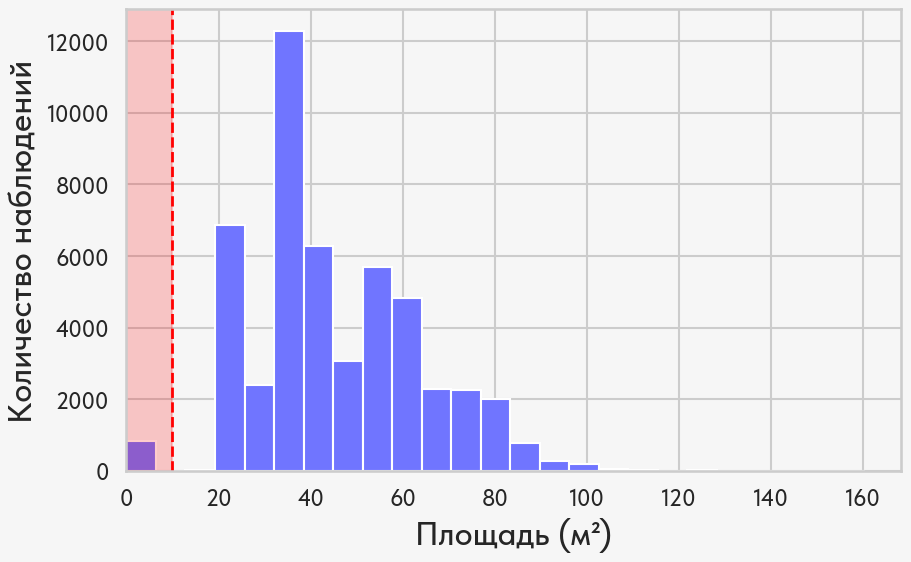

Медиана: 40.39, Среднее: 45.3586700574176, Ст. отклонение: 18.774325335465672


In [8]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    x=df['Площадь квартиры'].dropna(), 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

ax.axvline(x=10, color='red', linestyle='--', linewidth=2)
ax.axvspan(xmin=0, xmax=10, color='red', alpha=0.2)
ax.set_xlim(left=0) 

plt.xlabel('Площадь (м²)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)
plt.savefig('graphs/avg_lot_area_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(df['Площадь квартиры'].dropna())

ФИЛЬТРАЦИЯ

In [9]:
df = filter(df, df['Площадь квартиры'].notna() & (df['Площадь квартиры'] != 0))
print('After:', len(df))

0.9833906184809171
After: 49497


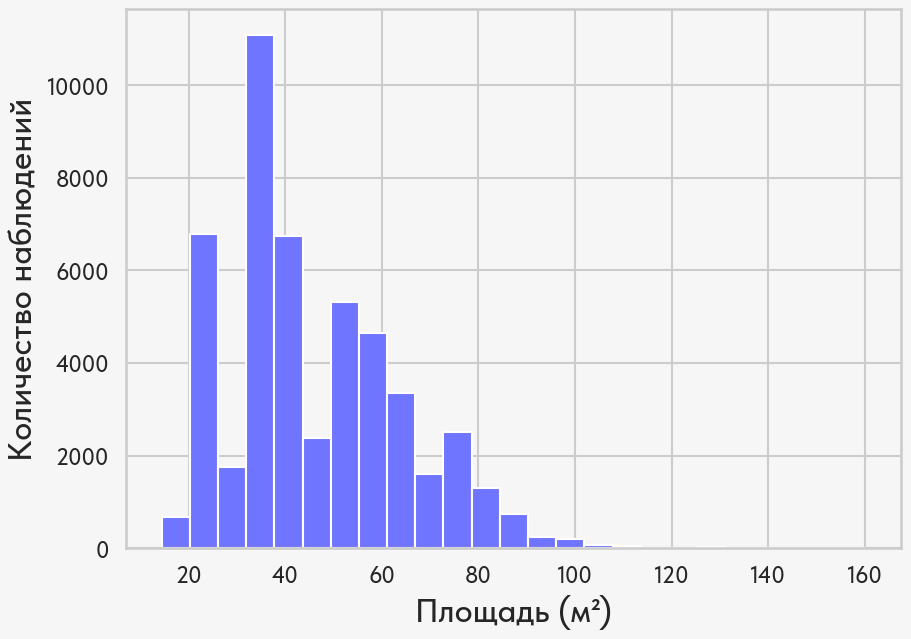

Медиана: 40.6, Среднее: 46.124774026708685, Ст. отклонение: 17.974749025661183


In [10]:
plt.figure(figsize=(10, 7))
ax = sns.histplot(
    x=df['Площадь квартиры'], 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Площадь (м²)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)
plt.savefig('graphs/avg_lot_area_distribution_not_zero.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(df['Площадь квартиры'])

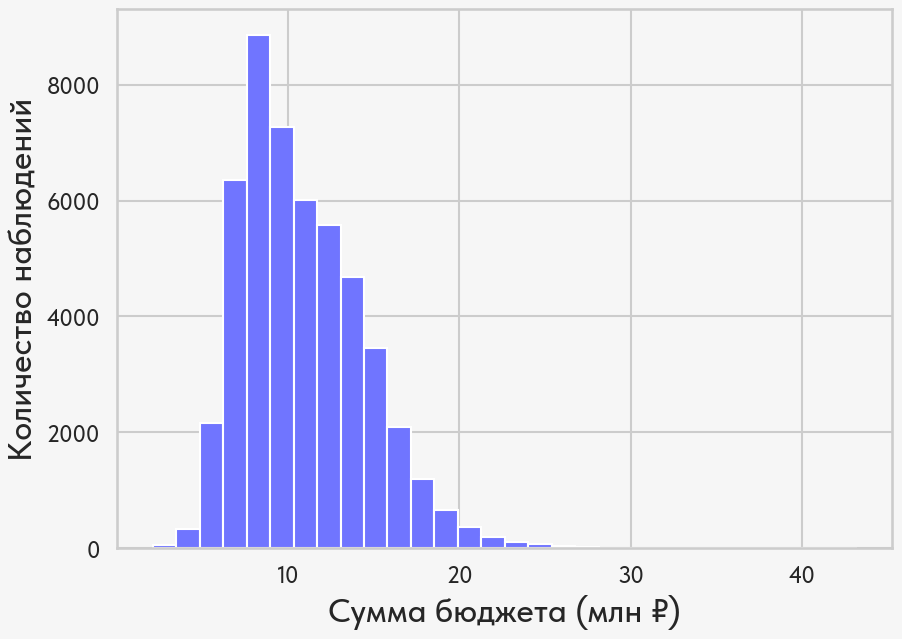

Медиана: 10.275581, Среднее: 10.895415343903267, Ст. отклонение: 3.6004079596903953


In [11]:
plt.figure(figsize=(10, 7))

x_data = df['Сумма бюджета'].dropna() / 1_000_000

ax = sns.histplot(
    x=x_data, 
    bins=30, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Сумма бюджета (млн ₽)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/budget_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

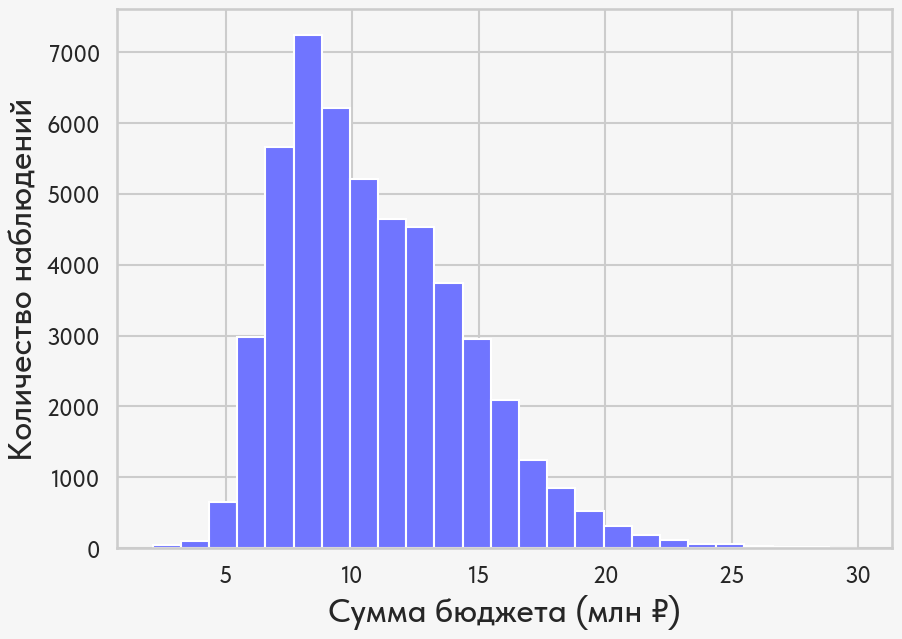

Медиана: 10.272857915, Среднее: 10.886879953279234, Ст. отклонение: 3.5740019817011914


In [12]:
plt.figure(figsize=(10, 7))

x_data = df[df['Сумма бюджета'] < 30000000]['Сумма бюджета'].dropna() / 1_000_000

ax = sns.histplot(
    x=x_data, 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Сумма бюджета (млн ₽)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/budget_distribution_obrez.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

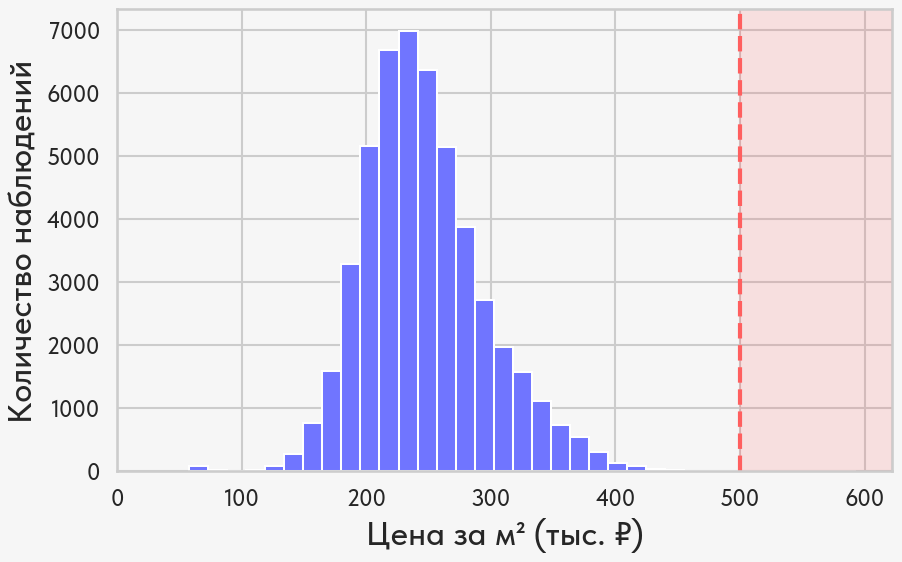

Медиана: 240.6, Среднее: 246.50449179461435, Ст. отклонение: 49.231317363676304


In [13]:
plt.figure(figsize=(10, 6))

x_data = df['Цена квадратного метра'].dropna() / 1000

ax = sns.histplot(
    x=x_data, 
    bins=35, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

ax.axvline(x=500, color='#ff5f5f', linestyle='--', linewidth=3)
ax.axvspan(xmin=500, xmax=x_data.max() * 1.05, color='#ff5f5f', alpha=0.15)

ax.set_xlim(left=0, right=x_data.max() * 1.05)

plt.xlabel('Цена за м² (тыс. ₽)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/price_sqm_distribution_limits.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

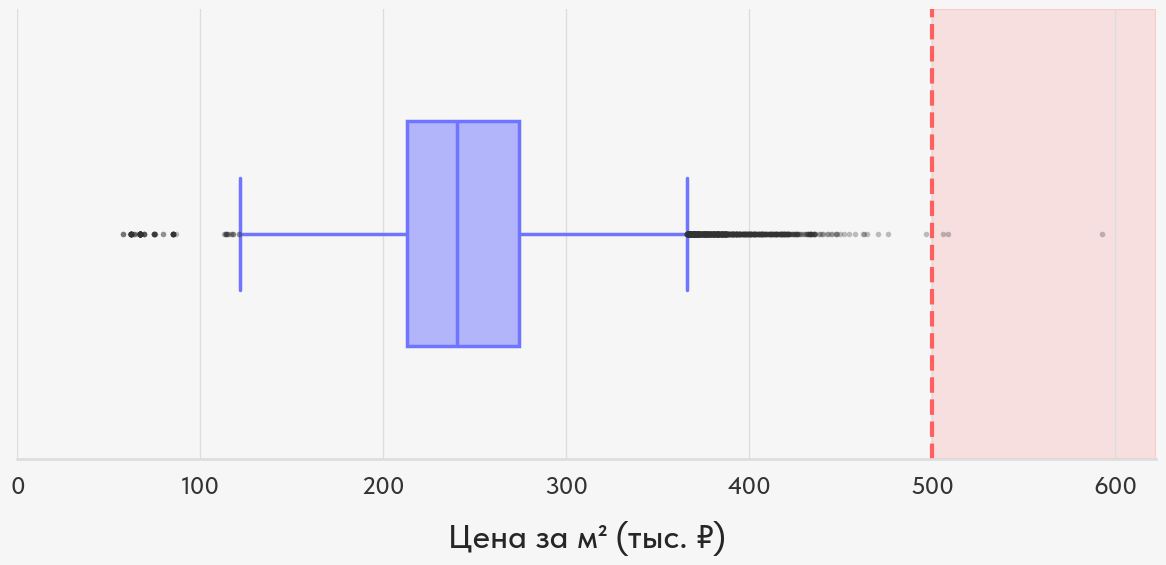

Медиана: 240.6, Среднее: 246.50449179461435, Ст. отклонение: 49.231317363676304


In [14]:
x_data = df['Цена квадратного метра'].dropna() / 1000
max_val = x_data.max() * 1.05

plt.figure(figsize=(12, 6))

box_facecolor = (112/255, 117/255, 255/255, 0.5)
line_color = '#7075FF'

flier_props = dict(
    marker='o', 
    markerfacecolor='#333333', 
    markersize=4,
    linestyle='none', 
    markeredgecolor='none', 
    alpha=0.3
)

median_props = dict(linestyle='-', linewidth=2.5, color=line_color)

ax = sns.boxplot(
    x=x_data, 
    flierprops=flier_props,
    boxprops=dict(facecolor=box_facecolor, edgecolor=line_color, linewidth=2.5),
    medianprops=median_props,
    whiskerprops=dict(color=line_color, linewidth=2.5),
    capprops=dict(color=line_color, linewidth=2.5),
    width=0.5
)

ax.axvline(x=500, color='#ff5f5f', linestyle='--', linewidth=3)
ax.axvspan(xmin=500, xmax=max_val, color='#ff5f5f', alpha=0.15, zorder=0)

ax.set_xlim(left=0, right=max_val)
ax.xaxis.grid(True, color='#dddddd', linestyle='-', linewidth=1)
ax.yaxis.grid(False)

sns.despine(left=True, bottom=False) 
ax.spines['bottom'].set_color('#dddddd')

plt.xlabel('Цена за м² (тыс. ₽)', fontproperties=font_prop, fontsize=24, labelpad=15)
plt.ylabel('', fontproperties=font_prop, fontsize=24)

for label in ax.get_xticklabels():
    label.set_fontproperties(font_prop)
    label.set_fontsize(18)
    label.set_color('#333333')

ax.set_yticks([])

plt.tight_layout()
plt.savefig('graphs/price_sqm_boxplot_styled.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

ФИЛЬТРАЦИЯ

In [15]:
df = filter(df, df['Цена квадратного метра'] < 500_000)
print('After:', len(df))

0.9999393902660767
After: 49494


In [16]:
print_stats(df['Цена квадратного метра'].dropna() / 1000)

Медиана: 240.59309514040947, Среднее: 246.48695634945244, Ст. отклонение: 49.180257007058096


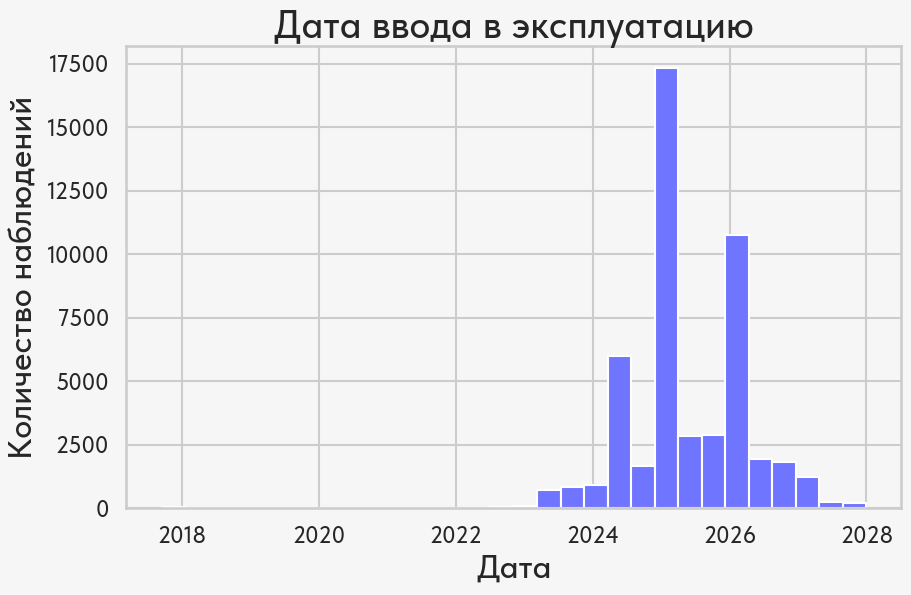

Медиана: 2025-03-31 00:00:00, Среднее: 2025-05-15 09:04:02.211176704, Ст. отклонение: 303 days 16:32:30.632593604


In [17]:
plt.figure(figsize=(10, 6))

x_data_actual = df['Дата ввода в эксплуатацию'].dropna()

sns.histplot(
    x=x_data_actual, 
    bins=30, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.title('Дата ввода в эксплуатацию', fontproperties=font_prop, fontsize=28)
plt.xlabel('Дата', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/date_actual_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data_actual)

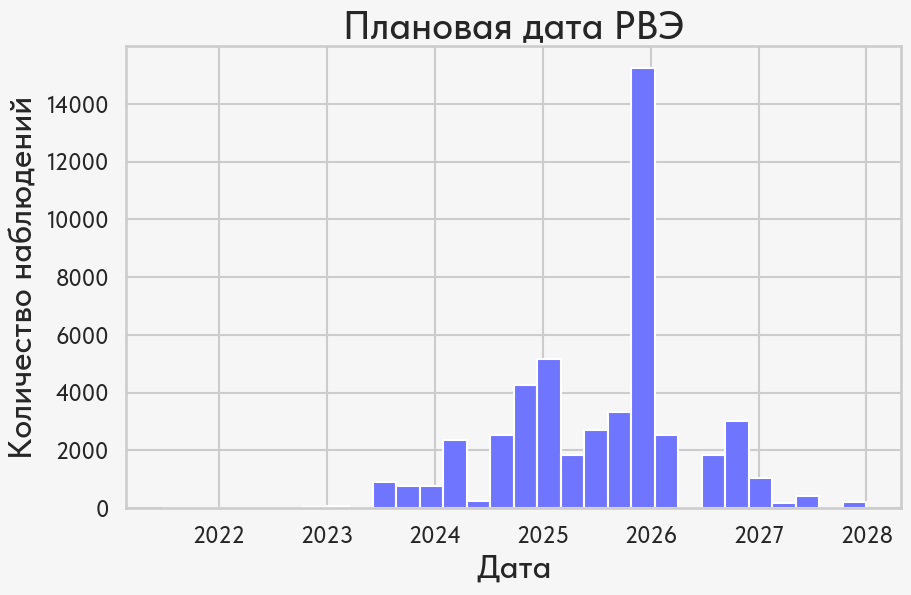

Медиана: 2025-03-31 00:00:00, Среднее: 2025-05-15 09:04:02.211176704, Ст. отклонение: 303 days 16:32:30.632593604


In [18]:
plt.figure(figsize=(10, 6))

x_data_plan = df['Плановая дата РВЭ'].dropna()

sns.histplot(
    x=x_data_plan, 
    bins=30, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.title('Плановая дата РВЭ', fontproperties=font_prop, fontsize=28)
plt.xlabel('Дата', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/date_planned_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data_actual)

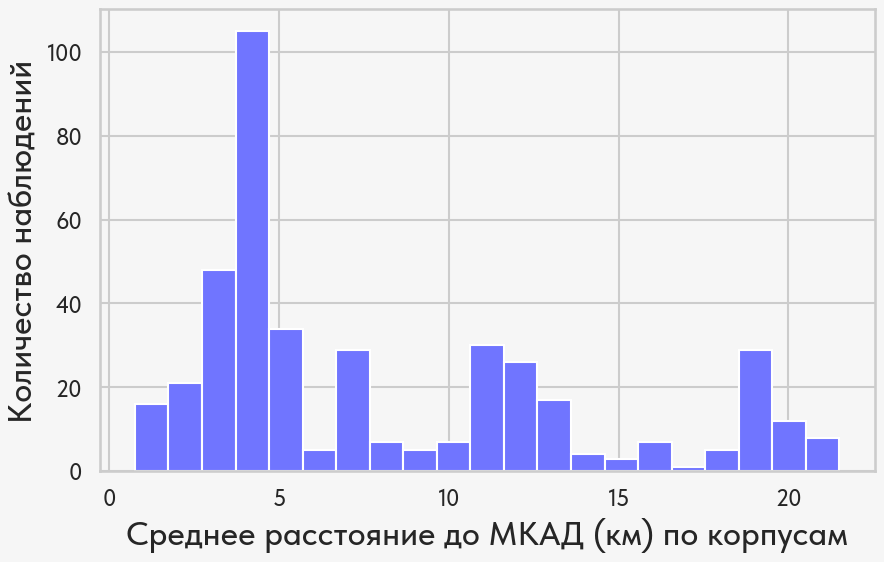

Медиана: 5.394, Среднее: 8.19447016706444, Ст. отклонение: 5.75460401540435


In [19]:
plt.figure(figsize=(10, 6))

x_data = df.groupby(['ID корпуса'])['mkad_dist_km'].mean().dropna()

ax = sns.histplot(
    x=x_data, 
    bins=21, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Среднее расстояние до МКАД (км) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/mkad_dist_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

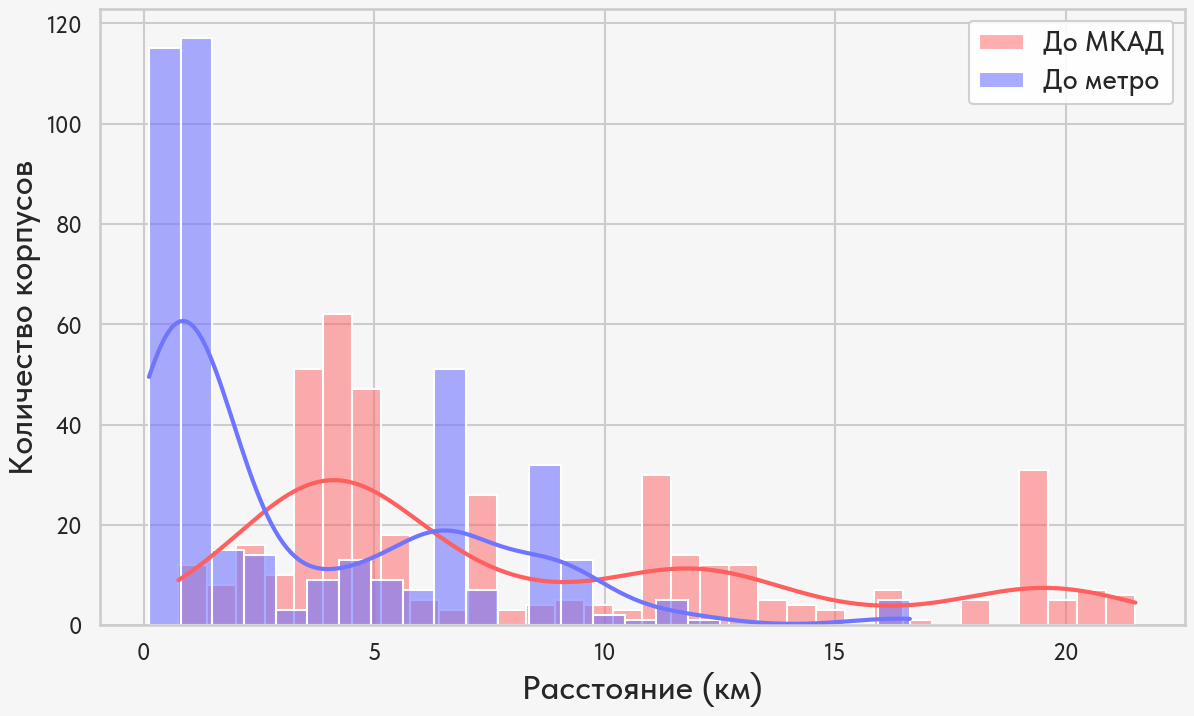

MKAD
Медиана: 5.394, Среднее: 8.19447016706444, Ст. отклонение: 5.75460401540435
METRO
Медиана: 1.276, Среднее: 3.357396181384248, Ст. отклонение: 3.519017828065632


In [20]:
data_mkad = df.groupby(['ID корпуса'])['mkad_dist_km'].mean().dropna()
data_metro = df.groupby(['ID корпуса'])['metro_dist_km'].mean().dropna()

plt.figure(figsize=(14, 8))

sns.histplot(
    x=data_mkad, 
    bins=33, 
    color='#FF5F5F',     
    edgecolor='white',
    alpha=0.5,           
    kde=True,            
    line_kws={'linewidth': 3},
    label='До МКАД'      
)

sns.histplot(
    x=data_metro, 
    bins=24, 
    color='#7075FF',     
    edgecolor='white',
    alpha=0.6,           
    kde=True,
    line_kws={'linewidth': 3},
    label='До метро'
)

plt.xlabel('Расстояние (км)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество корпусов', fontproperties=font_prop, fontsize=24)

legend = plt.legend(frameon=True, facecolor='white', framealpha=0.9, loc='upper right')
for text in legend.get_texts():
    text.set_fontproperties(font_prop)
    text.set_fontsize(20)

plt.savefig('graphs/mkad_vs_metro_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print('MKAD')
print_stats(data_mkad)
print('METRO')
print_stats(data_metro)

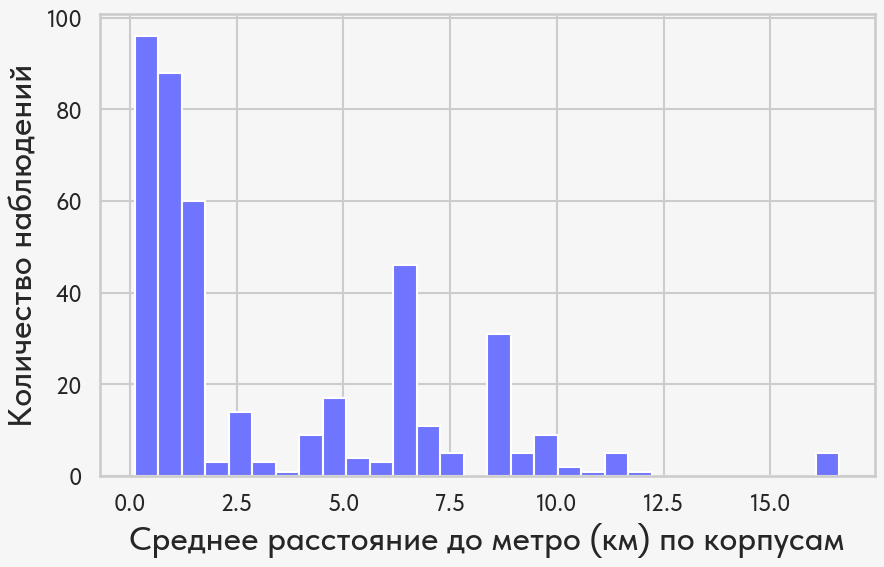

Медиана: 1.276, Среднее: 3.357396181384248, Ст. отклонение: 3.519017828065632


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

x_data = df.groupby(['ID корпуса'])['metro_dist_km'].mean().dropna()

ax = sns.histplot(
    x=x_data, 
    bins=30,
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Среднее расстояние до метро (км) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/metro_dist_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

## ФИЛЬТРАЦИЯ

In [22]:
print(len(df.groupby(['ID корпуса'])))

419


In [23]:
print('Before:', len(df))
df = filter(df, ~np.isnan(df['Плановая дата РВЭ'])) # Удалим один NaN
df = filter(df, df['Плановая дата РВЭ'] <= datetime.datetime(2025, 11, 1)) # Удаляем еще не сданные дома
print('After:', len(df))

Before: 49494
0.9999797955307714
0.5120724142808074
After: 25344


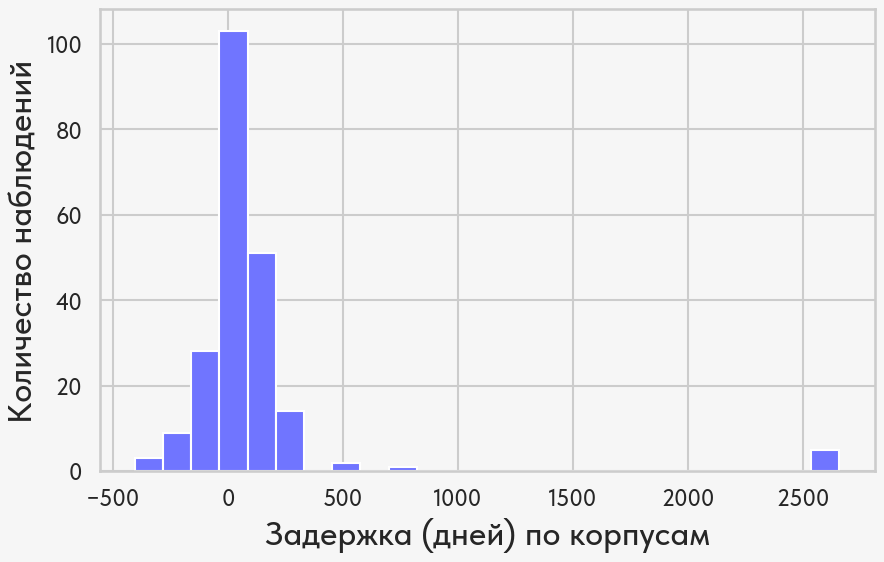

Медиана: 41.0, Среднее: 108.21296296296296, Ст. отклонение: 409.231135029694


In [24]:
plt.figure(figsize=(10, 6))

x_data = df.groupby(['ID корпуса'])['Задержка в днях'].median().dropna()

ax = sns.histplot(
    x=x_data, 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Задержка (дней) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/delay_days_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

In [25]:
df = filter(df, df['mkad_dist_km'] < 19)
print('After:', len(df))

0.9300820707070707
After: 23572


In [26]:
print(len(df.groupby(['ID корпуса'])))

179


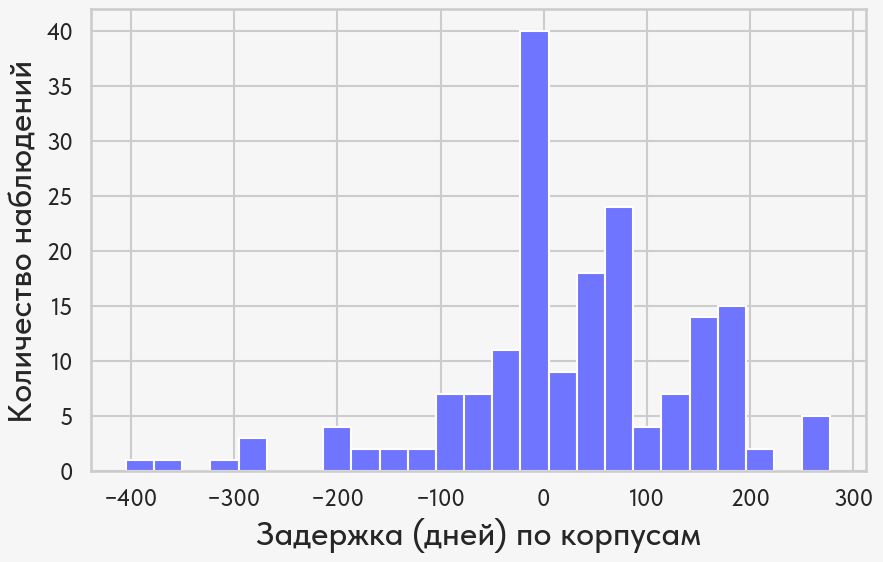

Медиана: 32.0, Среднее: 30.966480446927374, Ст. отклонение: 115.95446120082924


In [27]:
plt.figure(figsize=(10, 6))

x_data = df.groupby(['ID корпуса'])['Задержка в днях'].median().dropna()

ax = sns.histplot(
    x=x_data, 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Задержка (дней) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/delay_days_distribution_filtered.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

In [28]:
import plotly.graph_objects as go
import plotly.io as pio

x_data = df['Задержка в днях'].dropna()

fig = go.Figure()

fig.add_trace(go.Box(
    x=x_data,
    name='',              
    orientation='h',      
    
    line=dict(color='#7075FF', width=2),
    fillcolor='rgba(112, 117, 255, 0.5)',
    
    boxpoints='outliers', 
    marker=dict(
        color='#555555',
        size=6,
        opacity=0.6,
        symbol='circle'
    )
))

fig.update_layout(
    xaxis_title='Задержка (дней)',
    xaxis=dict(
        showgrid=True,
        gridcolor='#dddddd',
        
        zeroline=True,
        zerolinecolor='#dddddd',
        zerolinewidth=1,
        
        title_font=dict(size=24, family=font_name),
        tickfont=dict(size=18, family=font_name)
    ),
    yaxis=dict(
        showgrid=False,
        showticklabels=False
    ),
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)',
    width=1000, 
    height=600,
    font=dict(family=font_name),
    margin=dict(l=20, r=20, t=20, b=20)
)

# 4. Сохранение
fig.write_image("graphs/delay_days_boxplot_plotly.png", scale=3)
fig.show()

In [29]:
def plot_corr_style_template(corr_matrix,
                             feature_names,
                             outpath='graphs/heatmap_corr.png',
                             figsize=(10, 8),
                             cmap=None,
                             vmin=-1, 
                             vmax=1):
    if cmap is None:
        cmap = sns.color_palette("blend:#ff5f5f,#FFFFFF,#434afa", as_cmap=True)
    
    plt.figure(figsize=figsize)
    
    ax = sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cbar=False,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        xticklabels=feature_names,
        yticklabels=feature_names,
        linewidths=10,
        linecolor="#F6F6F6",
        square=True,
        cbar_kws={"shrink": 0.7, "pad": 0.03}
    )

    for text in ax.texts:
        try:
            text.set_fontproperties(font_prop)
        except NameError:
            pass
        text.set_fontsize(32)
        text.set_weight('medium')

    ax.set_xlabel('')
    ax.set_ylabel('')

    for tl in ax.get_xticklabels():
        try:
            tl.set_fontproperties(font_prop)
        except NameError:
            pass
        tl.set_rotation(0)
        tl.set_fontsize(20)
        
    for tl in ax.get_yticklabels():
        try:
            tl.set_fontproperties(font_prop)
        except NameError:
            pass
        tl.set_rotation(0)
        tl.set_fontsize(20)


    plt.tight_layout()
    plt.savefig(outpath, dpi=300, transparent=True, bbox_inches='tight')
    plt.show()

cols_to_corr = [
    'Задержка в днях', 
    'Цена квадратного метра',
    'mkad_dist_km', 
    'metro_dist_km', 
    'Этажей до'
]

cols_to_corr_names = [
    'Задержка (дни)', 
    'Цена м²',
    'Расстояние\nдо МКАД', 
    'Расстояние\nдо метро', 
    'Этажей'
]

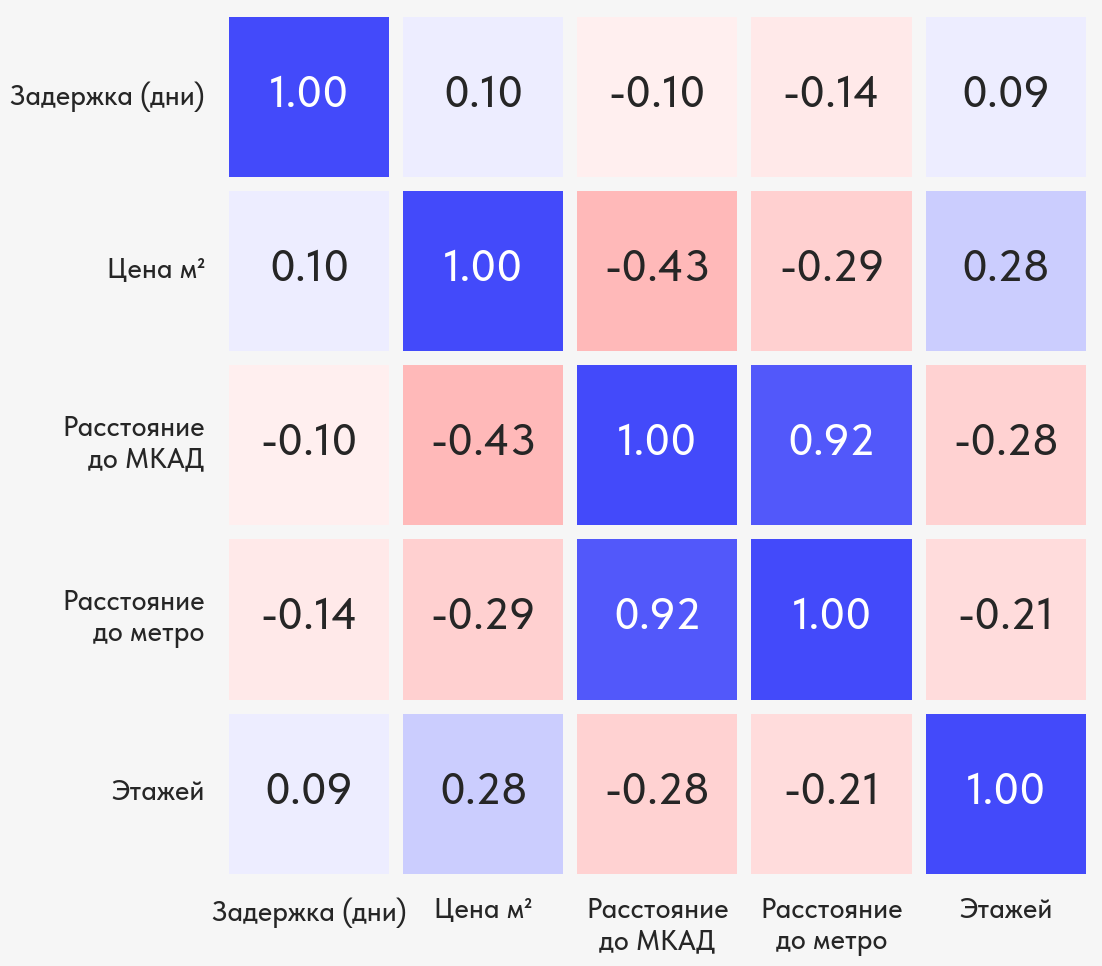

In [30]:
plot_corr_style_template(
    corr_matrix=df.groupby('ID корпуса')[cols_to_corr].mean().corr(), 
    feature_names=cols_to_corr_names,
    outpath='graphs/correlation_matrix.png',
    figsize=(12, 10)
)

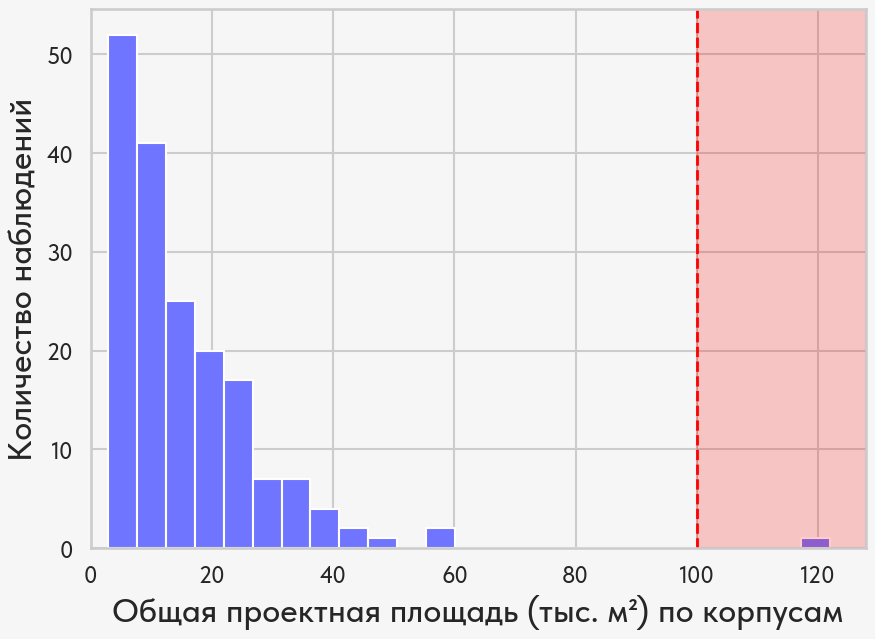

Медиана: 11.4595, Среднее: 15.831122011173186, Ст. отклонение: 13.21288813081036


In [31]:
plt.figure(figsize=(10, 7))

data = df.groupby('ID корпуса')['Общая проектная площадь'].mean().dropna() / 1000

ax = sns.histplot(
    x=data, 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

current_right_limit = ax.get_xlim()[1]

ax.axvline(x=100, color='red', linestyle='--', linewidth=2)

ax.axvspan(xmin=100, xmax=current_right_limit, color='red', alpha=0.2)

ax.set_xlim(left=0, right=current_right_limit)

plt.xlabel('Общая проектная площадь (тыс. м²) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)
plt.savefig('graphs/total_project_area_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(data)

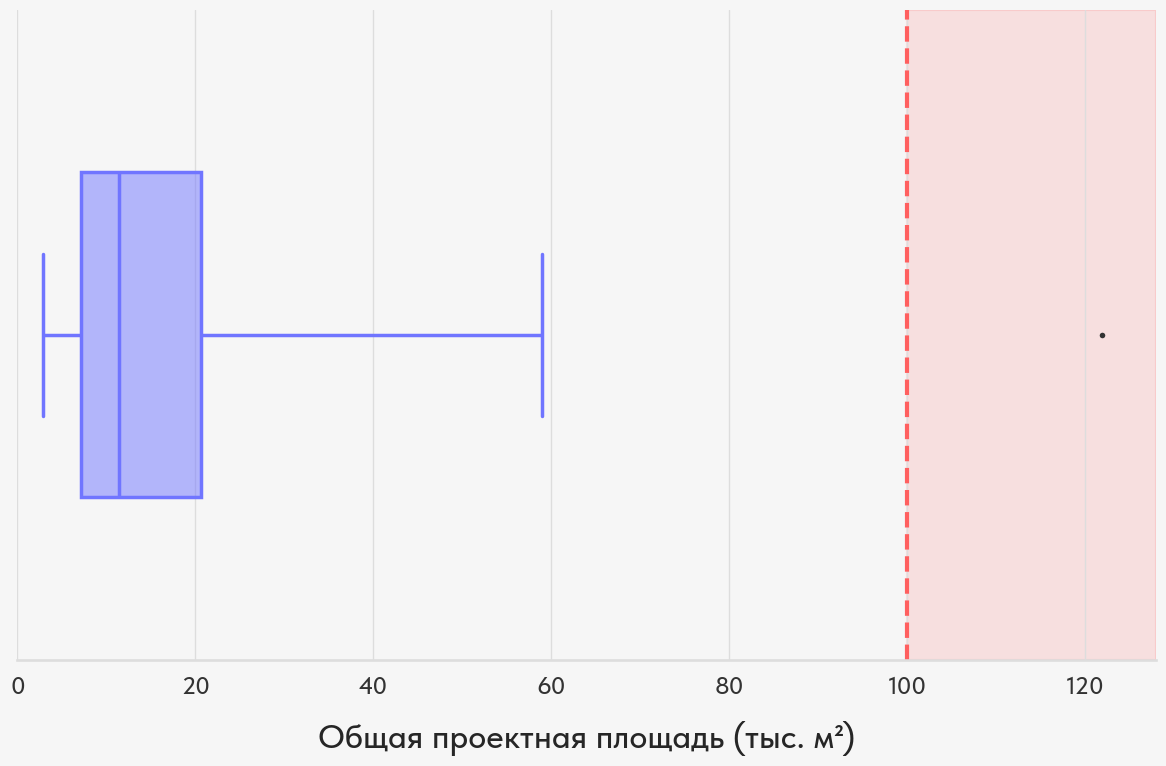

Статистика: Общая проектная площадь (тыс. м²)
Медиана: 11.4595, Среднее: 15.831122011173186, Ст. отклонение: 13.21288813081036


In [37]:
x_data = df.groupby('ID корпуса')['Общая проектная площадь'].mean().dropna() / 1000
max_val = x_data.max() * 1.05

plt.figure(figsize=(12, 8))

box_facecolor = (112/255, 117/255, 255/255, 0.5)
line_color = '#7075FF'

flier_props = dict(
    marker='o', 
    markerfacecolor='#333333', 
    markersize=4,
    linestyle='none', 
    markeredgecolor='none', 
    alpha=1
)

median_props = dict(linestyle='-', linewidth=2.5, color=line_color)

ax = sns.boxplot(
    x=x_data, 
    whis=3,
    flierprops=flier_props,
    boxprops=dict(facecolor=box_facecolor, edgecolor=line_color, linewidth=2.5),
    medianprops=median_props,
    whiskerprops=dict(color=line_color, linewidth=2.5),
    capprops=dict(color=line_color, linewidth=2.5),
    width=0.5
)

ax.axvline(x=100, color='#ff5f5f', linestyle='--', linewidth=3)
ax.axvspan(xmin=100, xmax=max_val, color='#ff5f5f', alpha=0.15, zorder=0)

ax.set_xlim(left=0, right=max_val)
ax.xaxis.grid(True, color='#dddddd', linestyle='-', linewidth=1)
ax.yaxis.grid(False)

sns.despine(left=True, bottom=False) 
ax.spines['bottom'].set_color('#dddddd')

plt.xlabel('Общая проектная площадь (тыс. м²)', fontproperties=font_prop, fontsize=24, labelpad=15)
plt.ylabel('', fontproperties=font_prop, fontsize=24)

for label in ax.get_xticklabels():
    label.set_fontproperties(font_prop)
    label.set_fontsize(18)
    label.set_color('#333333')

ax.set_yticks([])

plt.tight_layout()
plt.savefig('graphs/total_project_area_boxplot.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print("Статистика: Общая проектная площадь (тыс. м²)")
print_stats(x_data)

In [77]:
len(df), len(df.groupby('ID корпуса'))

(23572, 179)

ФИЛЬТР (ПОСЛЕДНИЙ)

In [78]:
df = filter(df, df['Общая проектная площадь'] <= 100_000)

print('After:', len(df))
print_stats(df.groupby('ID корпуса')['Общая проектная площадь'].mean().dropna() / 1000)

0.9577464788732394
After: 22576
Медиана: 11.420350000000001, Среднее: 15.23522943820225, Ст. отклонение: 10.566309570783197


In [79]:
len(df), len(df.groupby('ID корпуса'))

(22576, 178)

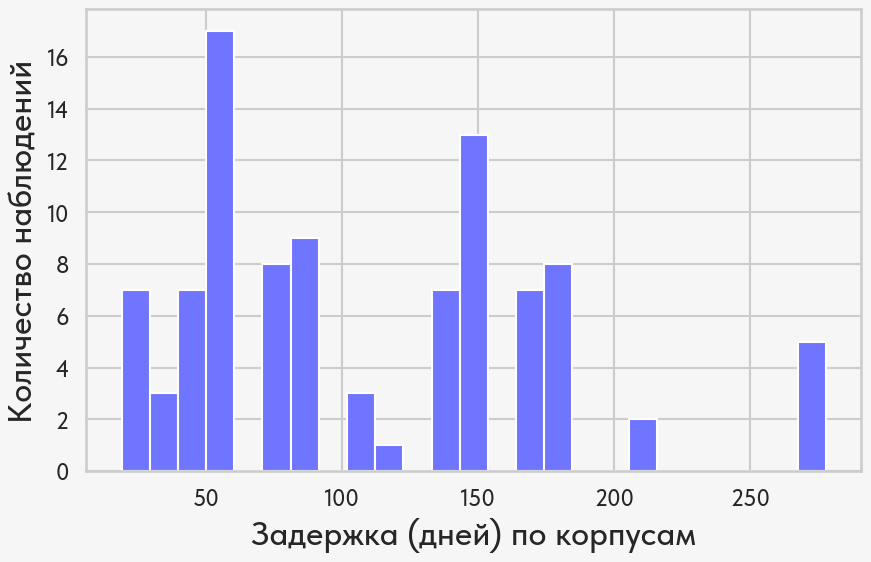

Медиана: 86.0, Среднее: 109.88659793814433, Ст. отклонение: 65.92070304044913


In [104]:
plt.figure(figsize=(10, 6))

x_data = df[df['Задержка в днях'] > 0].groupby(['ID корпуса'])['Задержка в днях'].median().dropna()

ax = sns.histplot(
    x=x_data, 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Задержка (дней) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/delay_days_distribution_filtered_only_plus.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

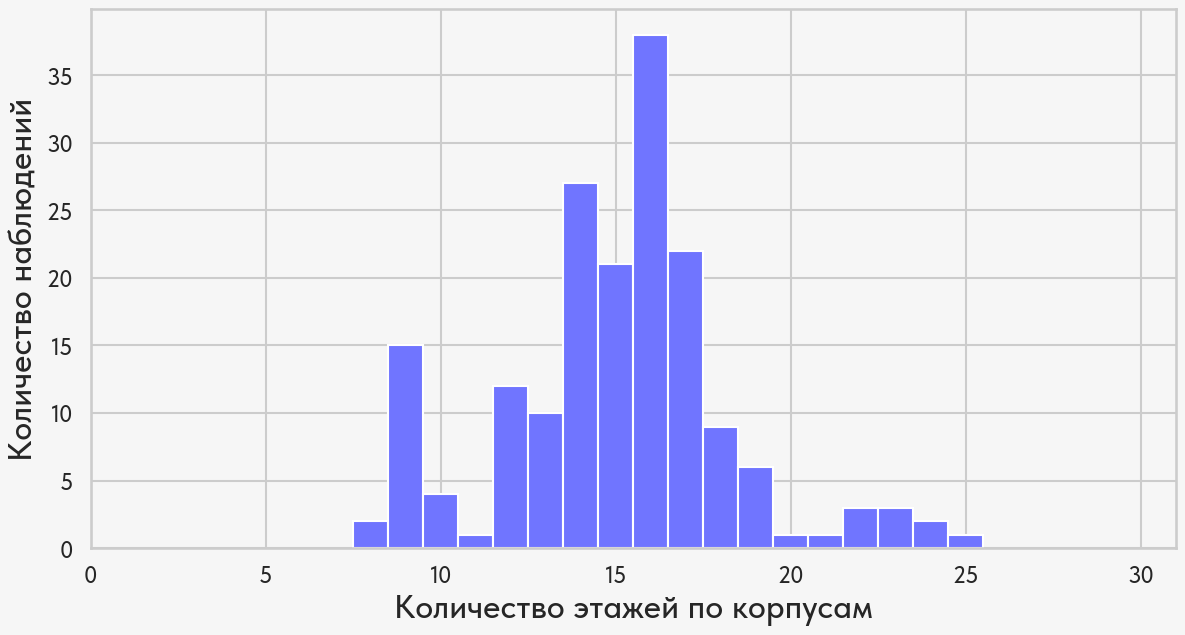

Медиана: 15.0, Среднее: 15.03370786516854, Ст. отклонение: 3.270997146476006


In [100]:
plt.figure(figsize=(14, 7))

data = df.groupby('ID корпуса')['Этажей до'].mean().dropna()

ax = sns.histplot(
    x=data, 
    discrete=True,
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

ax.set_xlim(left=0, right=31)

plt.xlabel('Количество этажей по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/floors_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(data)

In [101]:
df[(df['mkad_dist_km'] < 2)].groupby(['clean_address']).first()

,Название региона,Город,Район,Округ,Класс,Конструкция объекта,Застройщик,Название ЖК,Адрес корпуса,ID корпуса,...,Цена квадратного метра,Дней после начала продаж,Дней до ввода в эксплуатацию,Дней между началом продаж и вводом в эксплуатацию,Задержка в днях,Задержка,Сдача в срок,Ранняя сдача,Площадь квартиры,Доля уступок
clean_address,,,,,,,,,,,,,,,,,,,,,
"Москва, Дудкино деревня , корпус 1.1",Новая Москва,Дудкино дер.,НАО,Коммунарка,Комфорт,Монолит-блоки,Самолет,Тропарево Парк,"Дудкино дер., к. 1.1",9964f9e521f9f8637c81e8bbca7230e4,...,221118.990826,585,89,674,82.0,True,False,False,43.60,6.919431
"Москва, Дудкино деревня , корпус 1.2",Новая Москва,дер. Дудкино,НАО,Коммунарка,Комфорт,Монолит-блоки,Самолет,Тропарево Парк,"Дудкино дер., к. 1.2",3eb2ffd2d5b86ebece924c8ac9a762fc,...,359578.539854,548,89,637,82.0,True,False,False,23.21,6.919431
"Москва, Дудкино деревня , корпус 1.3",Новая Москва,Дудкино дер.,НАО,Коммунарка,Комфорт,Монолит-блоки,Самолет,Тропарево Парк,"Дудкино дер., к. 1.3",058fdcbb0875687e8a31f0e526e4a00d,...,187409.997433,487,89,576,82.0,True,False,False,77.92,6.919431
"Москва, Дудкино деревня , корпус 2.1",Новая Москва,Дудкино дер.,НАО,Коммунарка,Комфорт,Монолит-блоки,Самолет,Тропарево Парк,"Дудкино дер., к. 2.1",30a4c760a7c61fb1b7e1ccc764db76e1,...,289914.813815,284,546,830,268.0,True,False,False,37.06,6.919431
"Москва, Дудкино деревня , корпус 2.4",Новая Москва,дер. Дудкино,НАО,Коммунарка,Комфорт,Монолит-блоки,Самолет,Тропарево Парк,"Дудкино дер., к. 2.4",55d730f977631ed10d5059427d02ecf7,...,237749.569948,334,546,880,268.0,True,False,False,55.97,6.919431


In [81]:
import pandas as pd

df_grouped = df.groupby(['ID корпуса'])[['mkad_dist_km', 'Задержка в днях']].median()

df_grouped['mkad_dist_km_sq'] = df_grouped['mkad_dist_km'] ** 2

X = df_grouped[['mkad_dist_km', 'mkad_dist_km_sq']]
y = df_grouped['Задержка в днях']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     6.018
Date:                 Пн, 15 дек 2025   Prob (F-statistic):            0.00297
Time:                        23:00:15   Log-Likelihood:                -1092.6
No. Observations:                 178   AIC:                             2191.
Df Residuals:                     175   BIC:                             2201.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -49.7900     34.996     

In [82]:
df_grouped = df.groupby(['ID корпуса'])[['mkad_dist_km', 'Задержка в днях']].median()

scaler = StandardScaler()

df_grouped['mkad_std'] = scaler.fit_transform(df_grouped[['mkad_dist_km']])

df_grouped['mkad_std_sq'] = df_grouped['mkad_std'] ** 2

X = df_grouped[['mkad_std', 'mkad_std_sq']]
y = df_grouped['Задержка в днях']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     6.018
Date:                 Пн, 15 дек 2025   Prob (F-statistic):            0.00297
Time:                        23:00:15   Log-Likelihood:                -1092.6
No. Observations:                 178   AIC:                             2191.
Df Residuals:                     175   BIC:                             2201.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          63.1604     13.232      4.773      

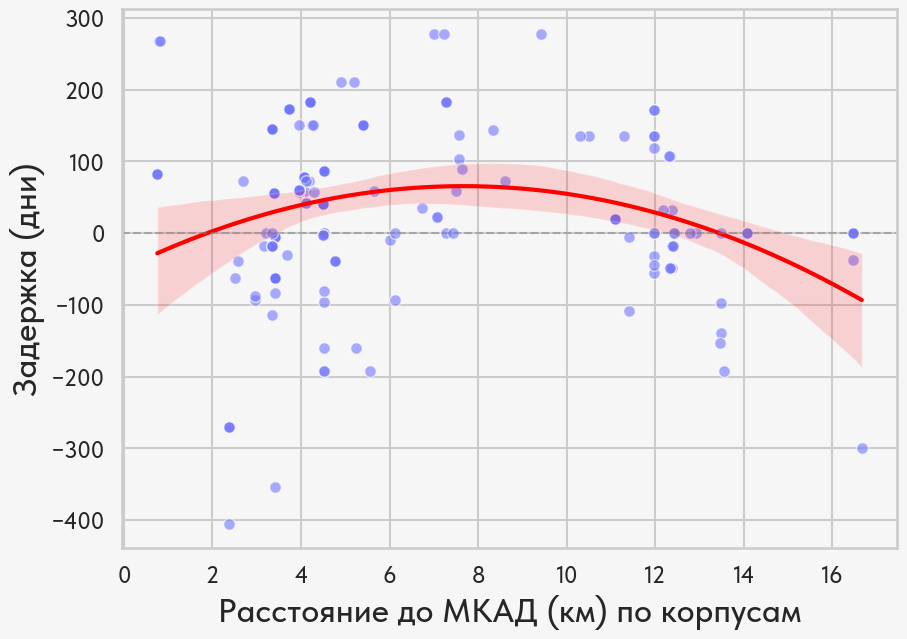

In [83]:
plt.figure(figsize=(10, 7))

sns.regplot(
    data=df.groupby(['ID корпуса'])[['mkad_dist_km', 'Задержка в днях']].median(),
    x='mkad_dist_km', 
    y='Задержка в днях', 
    order=2,
    scatter_kws={'color': '#7075FF', 'edgecolor': 'white', 'alpha': 0.6, 's': 70},
    line_kws={'color': 'red', 'linewidth': 3}
)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Задержка (дни)', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/mkad_dist_vs_delay_regplot.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

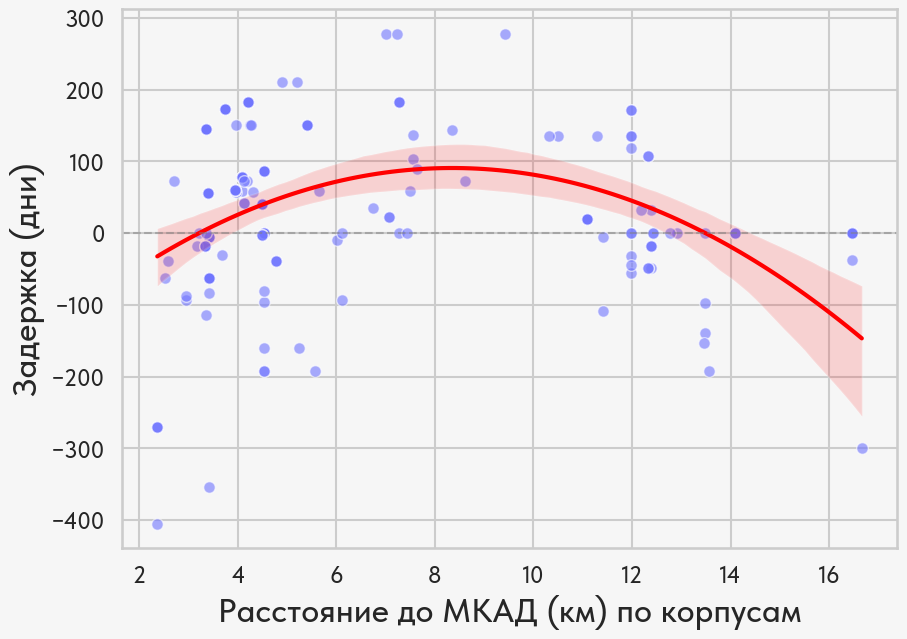

In [84]:
plt.figure(figsize=(10, 7))

sns.regplot(
    data=df[df['mkad_dist_km'] > 1].groupby(['ID корпуса'])[['mkad_dist_km', 'Задержка в днях']].median(),
    x='mkad_dist_km', 
    y='Задержка в днях', 
    order=2,
    scatter_kws={'color': '#7075FF', 'edgecolor': 'white', 'alpha': 0.6, 's': 70},
    line_kws={'color': 'red', 'linewidth': 3}
)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Задержка (дни)', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/mkad_dist_vs_delay_regplot_bolshe1.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

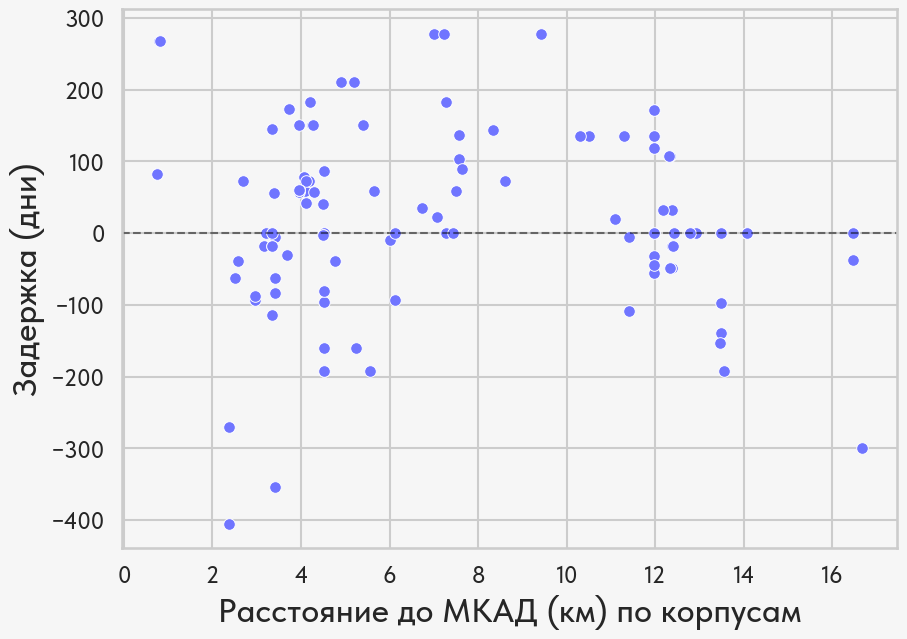

In [85]:
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=df.groupby(['ID корпуса'])[['mkad_dist_km', 'Задержка в днях']].median(),
    x='mkad_dist_km', 
    y='Задержка в днях', 
    color='#7075FF', edgecolor='white', alpha=1, s=70
)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Задержка (дни)', fontproperties=font_prop, fontsize=24)

plt.savefig('graphs/mkad_dist_vs_delay_scatterplot.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Уравнение красной линии: $y = -1.96x^2 + 30.04x - 49.79$


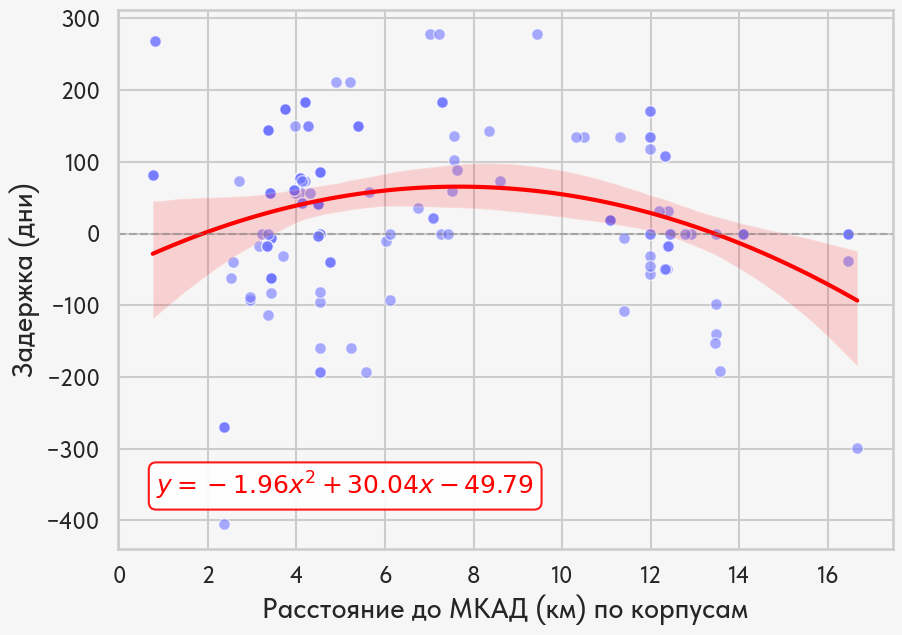

In [86]:
df_agg = df.groupby(['ID корпуса'])[['mkad_dist_km', 'Задержка в днях']].median().dropna()

x = df_agg['mkad_dist_km']
y = df_agg['Задержка в днях']

z = np.polyfit(x, y, 2)
p = np.poly1d(z)

sign_b = "+" if z[1] >= 0 else "-"
sign_c = "+" if z[2] >= 0 else "-"
eq_text = f"$y = {z[0]:.2f}x^2 {sign_b} {abs(z[1]):.2f}x {sign_c} {abs(z[2]):.2f}$"

print("Уравнение красной линии:", eq_text)

plt.figure(figsize=(10, 7))

sns.regplot(
    data=df_agg,
    x='mkad_dist_km', 
    y='Задержка в днях', 
    order=2,
    scatter_kws={'color': '#7075FF', 'edgecolor': 'white', 'alpha': 0.6, 's': 70},
    line_kws={'color': 'red', 'linewidth': 3}
)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

plt.text(0.05, 0.1, eq_text, transform=plt.gca().transAxes, 
         fontsize=18, color='red', weight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9))

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontsize=20)
plt.ylabel('Задержка (дни)', fontsize=20)

plt.grid(True)
plt.savefig('graphs/mkad_dist_vs_delay_regplot_eq.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Уравнение красной линии: $y = -3.44x^2 + 57.39x - 149.03$


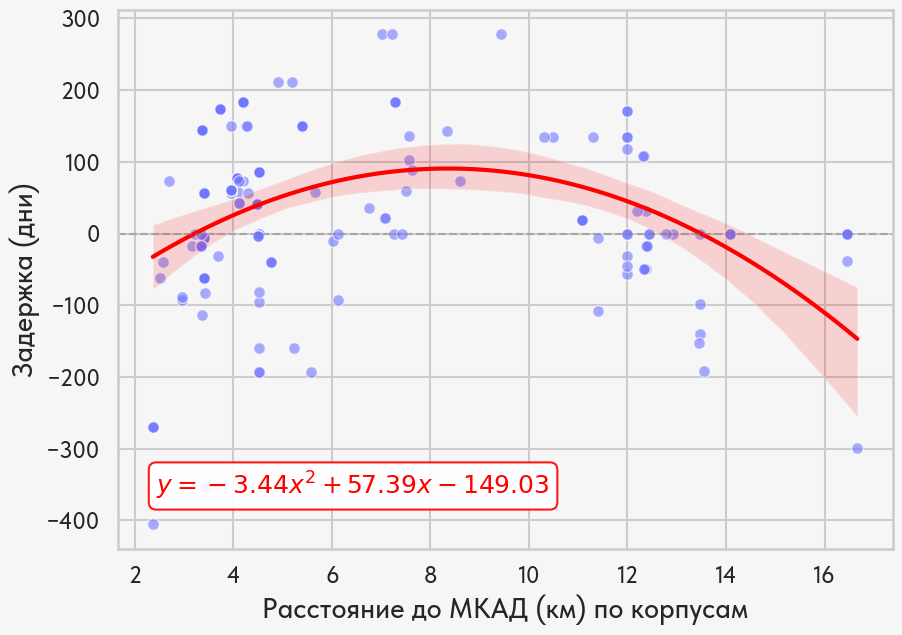

In [87]:
df_agg = df[df['mkad_dist_km'] > 1].groupby(['ID корпуса'])[['mkad_dist_km', 'Задержка в днях']].median().dropna()

x = df_agg['mkad_dist_km']
y = df_agg['Задержка в днях']

z = np.polyfit(x, y, 2)
p = np.poly1d(z)

sign_b = "+" if z[1] >= 0 else "-"
sign_c = "+" if z[2] >= 0 else "-"
eq_text = f"$y = {z[0]:.2f}x^2 {sign_b} {abs(z[1]):.2f}x {sign_c} {abs(z[2]):.2f}$"

print("Уравнение красной линии:", eq_text)

plt.figure(figsize=(10, 7))

sns.regplot(
    data=df_agg,
    x='mkad_dist_km', 
    y='Задержка в днях', 
    order=2,
    scatter_kws={'color': '#7075FF', 'edgecolor': 'white', 'alpha': 0.6, 's': 70},
    line_kws={'color': 'red', 'linewidth': 3}
)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

plt.text(0.05, 0.1, eq_text, transform=plt.gca().transAxes, 
         fontsize=18, color='red', weight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9))

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontsize=20)
plt.ylabel('Задержка (дни)', fontsize=20)

plt.grid(True)
plt.savefig('graphs/mkad_dist_vs_delay_regplot_bolshe1_eq.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Уравнение красной линии: $y = -5.79x^2 + 92.86x - 251.73$


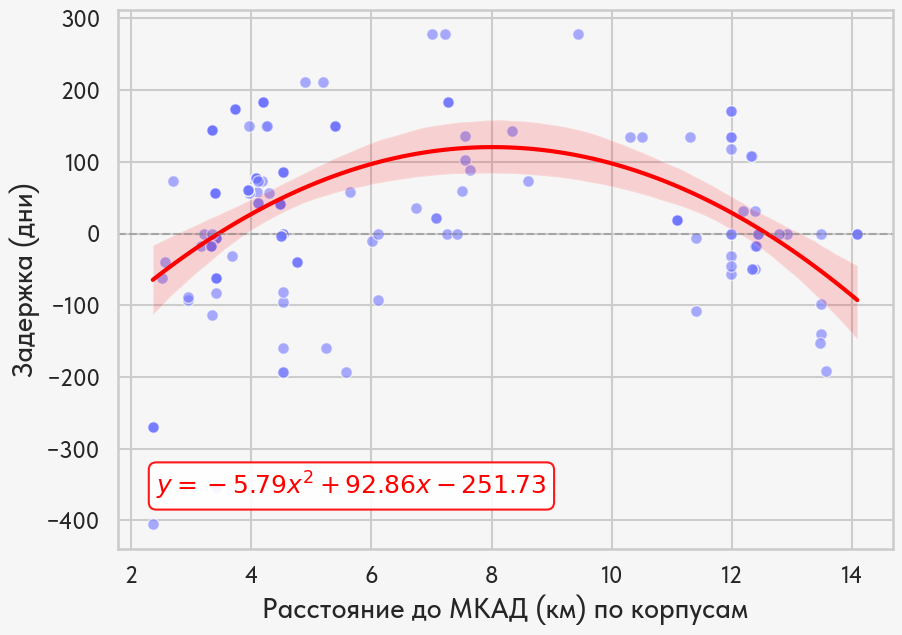

In [95]:
df_agg = df[(df['mkad_dist_km'] > 1) & (df['mkad_dist_km'] < 16)].groupby(['ID корпуса'])[['mkad_dist_km', 'Задержка в днях']].median().dropna()

x = df_agg['mkad_dist_km']
y = df_agg['Задержка в днях']

z = np.polyfit(x, y, 2)
p = np.poly1d(z)

sign_b = "+" if z[1] >= 0 else "-"
sign_c = "+" if z[2] >= 0 else "-"
eq_text = f"$y = {z[0]:.2f}x^2 {sign_b} {abs(z[1]):.2f}x {sign_c} {abs(z[2]):.2f}$"

print("Уравнение красной линии:", eq_text)

plt.figure(figsize=(10, 7))

sns.regplot(
    data=df_agg,
    x='mkad_dist_km', 
    y='Задержка в днях', 
    order=2,
    scatter_kws={'color': '#7075FF', 'edgecolor': 'white', 'alpha': 0.6, 's': 70},
    line_kws={'color': 'red', 'linewidth': 3}
)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

plt.text(0.05, 0.1, eq_text, transform=plt.gca().transAxes, 
         fontsize=18, color='red', weight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9))

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontsize=20)
plt.ylabel('Задержка (дни)', fontsize=20)

plt.grid(True)
plt.savefig('graphs/mkad_dist_vs_delay_regplot_bolshe1_menshe16_eq.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [99]:
a = len(df[(df['mkad_dist_km'] > 1) & (df['mkad_dist_km'] < 16)].groupby(['ID корпуса']))
n = len(df.groupby(['ID корпуса']))

(n - a) / n, a, n

(0.06179775280898876, 167, 178)

In [98]:
df_grouped = df[(df['mkad_dist_km'] > 1) & (df['mkad_dist_km'] < 16)].groupby(['ID корпуса'])[['mkad_dist_km', 'Задержка в днях']].median()

df_grouped['mkad_dist_km_sq'] = df_grouped['mkad_dist_km'] ** 2

X = df_grouped[['mkad_dist_km', 'mkad_dist_km_sq']]
y = df_grouped['Задержка в днях']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     17.53
Date:                 Пн, 15 дек 2025   Prob (F-statistic):           1.26e-07
Time:                        23:18:07   Log-Likelihood:                -1011.1
No. Observations:                 167   AIC:                             2028.
Df Residuals:                     164   BIC:                             2037.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -251.7313     50.096     